<a href="https://colab.research.google.com/github/wdconinc/practical-computing-for-scientists/blob/master/Lectures/lecture27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lectures 27: Random Numbers and Monte Carlo Methods

<img src="https://imgs.xkcd.com/comics/random_number.png"/>

In [0]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
import numpy.random as ran

##Real random numbers

Imagine I have a radioactive source which decays at a rate $\lambda$. I start a clock and record the time elapsed to the first decay, $t_0$. I then restart the clock and measure the time to the next decay $t_1$, and so on, building up an ensemble $\{t_i\}$. If I histogrammed these times I would find that they follow an exponential distribution:

$$ p(t) dt = \lambda e^{-\lambda t} dt \quad \mbox{probability of a decay happening between $t$ and $t+dt$} $$

Note, $\int_{0}^{+\infty} p(t) dt = 1$ and $p(t)$ is a probability distribution function (PDF).

###Generating uniform deviates

We'd like to generate random numbers according to various distributions (exponential, Gaussian, Poisson, etc). The starting point in each of those cases is a set of _uniform deviates_, numbers that uniformly occupy the range [0,1). With a natural source of $\{t_i\}$ we can build up a uniform deviate according to the following procedure (due to Von Neumann):
1. Build a random sequence of 0s and 1s $\{b_i\}$ according to :
$$ b_i = \left\{ \begin{array}{ll}
         1 & \mbox{if $ t_{i+1}>t_{i}$};\\
         0 & \mbox{otherwise}.\end{array} \right. $$
 * this picks 0 or 1 with a 50% chance
 * it is crucial that $t_{i}$ and $t_{i+1}$ are independent, as with a radioactive source.
2. Then use the $\{b_i\}$ to fill in the random bits of a floating point number `0.F`, where `F` is, in the IEEE-754 standard, a 23 or 52 bit mantissa.

##Generating exponentially distributed random numbers

Suppose I have a set of uniform deviates $x_i$. How can I use them to generate a sequence of deviates $y_i$ distributed according to an exponential distribution with arbitrary $\lambda$?

First let $p_{x}(x)$ be the PDF of $x$. We are trying to find a procedure to compute $y(x)$ following the exponential PDF $p_{y}(y)$. By construction we have:

$$\int_0^1 p_{x}(x) dx=1$$

We can then change variables from x to y:

$$\int_0^1 p_{x}(x) dx = \int_{y(0)}^{y(1)} p_{x}(y(x)) \left| \frac{dx}{dy} \right| dy = 1$$

However, by also by construction we have: 

$$ \int_{y_{low}}^{y_{high}} p_{y}(y) dy = 1$$

which leads to: 

$$ p_{y}(y) = p_{x}(y(x)) \left| \frac{dx}{dy} \right| $$

Now, $p_x(x)=1$ since $x$ is a uniform deviate and, since there are no powers of $x$ on the right hand side, $p_x(y(x))=1$ as well. Therefore $p_{y}(y) = \left| \frac{dx}{dy} \right|$. Let's keep the goal in mind: we want $y$ to be exponentially distributed and thus need to pick a function $x(y)$ such that $\left| \frac{dx}{dy} \right| = \lambda e^{-\lambda y}$. We are in luck, that's easy, $x(y) = e^{-\lambda y}$ does the trick.

So, taking stock, we've learned that $p_y(y) = \lambda e^{-\lambda y}$ and $p_x(x)=1$ are simultaneously satisfied if $x(y) = e^{-\lambda y}$. Moreover, we can invert the function to write $y(x) = - \frac{1}{\lambda}\ln(x)$, and we have a way to generate exponentially distributed deviates $y$ from uniform deviates $x$. The exponentials are valid over the range $y_{low}=y(1)=0$ to $y_{high}=y(0)=+\infty$. Note, it may seem natural to assign $y_{low}=y(0)=+\infty$ and $y_{high}=y(1)=0$, but that leads to the wrong normalization for a PDF:

$$ \int_{+\infty}^{0} p_{y}(y) dy = -1$$




(array([9495., 8805., 7758., 7076., 6418., 5832., 5233., 4735., 4235.,
        3843., 3412., 3176., 2959., 2577., 2288., 2088., 1928., 1743.,
        1542., 1404., 1220., 1165., 1041.,  951.,  881.,  784.,  709.,
         612.,  596.,  546.,  487.,  416.,  374.,  341.,  295.,  282.,
         267.,  246.,  207.,  193.,  170.,  185.,  137.,  125.,  119.,
          84.,   95.,   84.,   72.,   73.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
        3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
 <a list of 50 Patch objects>)

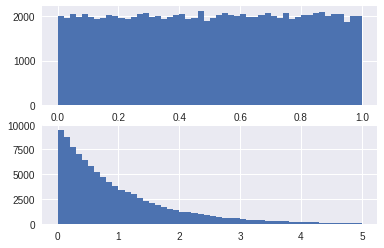

In [0]:
def expodev(x,beta):
    ''' generate a set of exponentially distributed numbers y from uniform deviates x'''
    return -1 / beta * np.log(x)

x = ran.rand(100000)
plt.subplot(211)
plt.hist(x, 50, range = (0,1))

plt.subplot(212)
plt.hist(expodev(x,1.0), 50, range = (0,5))

##How to generate deviates from a distribution of choice

###The transformation method

The transformation method generalizes the procedure we used to generate exponentially distributed random numbers from uniform random numbers. The general situation is that we want to compute a sequence $\{y_i\}$ distributed according to $p(y)$ from a set of uniform deviates $\{x_k\}$. Knowing $p(y)$ we can compute the cumulative distribution function 
$$F(y) = \int_0^y p(y) dy $$
which is just the area under the curve $p(y)$ to the left of y. Since $p(y)$ is a PDF, $F(y)$ has a range $[0,1]$. The inverse of $F$, $F^{-1}$, maps values evenly spread along the vertical axis to values along the horizontal axis as shown in the diagram below. If we can find $F^{-1}$ then we are in business, since we can now compute $y_i = F^{-1}(x_i)$.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/Inverse_transformation_method_for_exponential_distribution.jpg/800px-Inverse_transformation_method_for_exponential_distribution.jpg" width="50%">

###The acceptance / rejection method

No, it's not about your love life! It's what you do when you encounter an unlovable distribution $p(y)$ for which $F^{-1}$ cannot be found. 

The idea is to find a function $f(y)$ which "envelopes" $p(y)$ but for which we can compute the inverse CDF $F^{-1}$. Then, we generate a uniform deviate $x_i$ and use it along with $F^{-1}$ to find a $y_{i}$.  We can now compute $f(y_i)$ and $p(y_i)<f(y_i)$ and we generate a second uniform deviate $x$, this time on the interval  $\left[0,f(y_i)\right)$. If $x<p(y_i)$ then we accept $y_i$ as a deviate following $p(y_i)$. Otherwise we reject it and restart the process, generating a new uniform deviate $x_{i+1}$.  

The choice of $f(y)$ is arbitrary, but clearly the process is most efficient if $f(y)$ closely envelopes $p(y)$. 

<img src="https://qph.fs.quoracdn.net/main-qimg-21c2e401c3e2a9c06386793c20a77877" width="50%">

Text(0.5,1,'Rejection sampling')

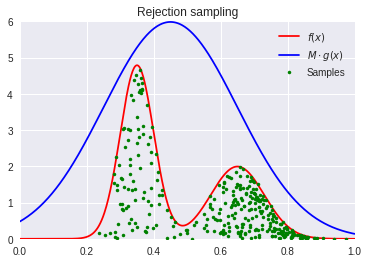

In [0]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

M = 3
# Number of samples to draw from the probability estimation function
N = 5000

# The target probability density function
f = lambda x: 0.6 * norm.pdf(x, 0.35, 0.05) + 0.4 * norm.pdf(x, 0.65, 0.08)
# The approximated probability density function
g = lambda x: norm.pdf(x, 0.45, 0.2)

# A number of samples, drawn from the approximated probability density function
x_samples = M * np.random.normal(0.45, 0.2, (N,))

# A number of samples in the interval [0, 1]
u = np.random.uniform(0, 1, (N, ))

# Now examine all the samples and only use the samples found by rejection sampling
samples = [(x_samples[i], u[i] * M * g(x_samples[i])) for i in range(N) if M * g(x_samples[i]) * u[i] < f(x_samples[i])]

# The x coordinates
x = np.linspace(0, 1, 500)

# The target probability function
plt.plot(x, f(x), 'r-', label='$f(x)$')

# The approximated probability density function
plt.plot(x, M * g(x), 'b-', label='$M \cdot g(x)$')

# The samples found by rejection sampling
plt.plot([sample[0] for sample in samples], [sample[1] for sample in samples], 'g.', label = 'Samples')

plt.xlim([0, 1])
plt.ylim([0, 6])

plt.legend()
plt.title('Rejection sampling')

##An example random number generator

It's rather simple, an example of a _linear congruential generator_. The algorithm takes constants $a,c$ and $m$ and a initial positive integer $t_0$ (the seed) and generates a sequence of random numbers $x_i$ according to:

\begin{align}
t_i & = (a t_{i-1} + c) \mod m\\
x_i & = t_i/m
\end{align}

The default values $a=65539$, $m=2^{31}$ and $c=0$ are shown in the class below. Evidently, our first guess places $a t_0$ somewhere on the line of positive integers, then the modulus places $t_1$ somewhere between $0$ and $m$, and finally the division by $m$ yields a result between $0$ and $1$. We then carry on, generating $t_2$ and $x_2$ from $t_1$, and so on. We implemented the algorithm as part of a python `class` because classes have _state_, that is they carry data which they retain between calls to their functions.


Note: Don't ever actually use this generator! See below.

In [0]:
class myrand:
    def __init__(self, seed, a = 65539, c = 0, m = 2**31): #constructor
        self.t = seed
        self.a = a
        self.c = c
        self.m = m
    def random(self):
        self.t = (self.a*self.t + self.c) % self.m
        return self.t / self.m

r = myrand(10139)
print(r.random())
print(r.random())
print(r.random())
print(r.random())

0.30943188862875104
0.8565488397143781
0.35440604062750936
0.41749668633565307


###The output in 1D

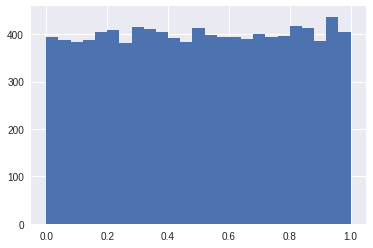

In [0]:
plt.hist([r.random() for i in range(10000)], 25, range = (0,1));

###The output in 2D

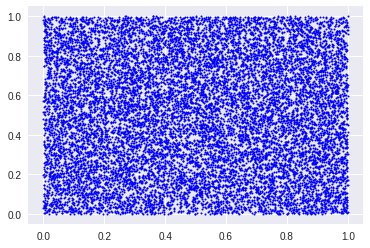

In [0]:
random_nums = [r.random() for i in range(30000)]
plt.plot(random_nums[::2], random_nums[1::2], 'ob', ms = 2);

###The output in 3D

In [0]:
from mpl_toolkits.mplot3d import Axes3D

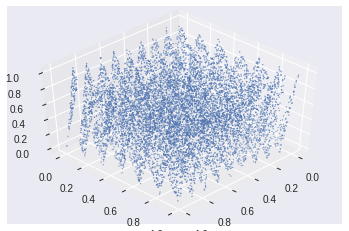

In [0]:
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax.view_init(elev = 45, azim = 45)
ax.scatter3D(random_nums[0::3], random_nums[1::3], random_nums[2::3], s = 1);

__NOTE:__ This is the _infamous_ RANDU random number generator, popular in the 1960's-70's! It's seriously flawed as you can see from the 3D plot. You never actually want to use it!

> **The generation of random numbers is too important to be left to chance.** (Robert R. Coveyou)

##Using the `scipy` generator

The generator in `scipy` is accessible from the `numpy.random` module. A little digging shows that it uses the so-called _Mersenne Twister algorithm_. This algorithm, written in 1998, is by far the most popular technique for generating random numbers. It is the default algorithm in Matlab and ROOT (particle physics analysis software), and it's available in Mathematica (though perhaps not the default). It's also the default algorithm for the regular old `random` module in python.  The name comes from the fact that the algorithm is has a period equal to the Mersenne prime $2^{19937}-1$, a ridiculously large number $\approx 10^{6001}$.

__Citation:__ Matsumoto, M., & Nishimura, T. (1998). Mersenne twister: A 623-dimensionally equidistributed uniform pseudo-random number generator. ACM Transactions on Modeling and Computer Simulation, 8(1), 3-30. http://search.proquest.com/docview/26677636?accountid=15053

In [0]:
random_nums = ran.rand(30000)
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax.view_init(elev = 45,azim = 45)
ax.scatter3D(random_nums[0::3], random_nums[1::3], random_nums[2::3], s = 1)

##Recommendations on generators

Generators have become much better in the last 20 years and a bit of cursory research suggests that the default generator in many popular software packages is likely good enough for your use. However there are a few things to keep in mind:
* Figure out what algorithm is being used.
* Figure out if that algorithm has passed the so-called "diehard battery" of statistical tests.
 * Note, even if you are using a generator implemented with a classy algorithm like the Mersenne Twister, it's likely that the actual code was written specifically for the software package in question. Therefore, you'd like to know that your actual generator passes the diehard tests.
* Numerical Recipes recommends using a generator with a period $>2^{64}$. These days, it may be hard to find an algorithm with a _shorter_ period than that!
* Be careful with the seed. If you use a generator to do job A, and then use the same generator to do job B, the results will be subtly correllated if the generator was initialized with the same seed. 
 * I cannot count the number of times I've seen this happen in particle physics research. Most graduate students can look back on at least one such oopsie.  
 * Generally, in particle physics research, we choose the seed manually so as to get repeatable results and assure that different jobs are not correlated.
 * Some generators may try to initialize the seed with a random number from the operating system's random number generator. On linux machines this is `/dev/urandom`, which supplies random bits gathered from environmental noise from device drivers and other sources into a so-called "entropy  pool".
 
 

##Some distributions

In [0]:
r = ran.RandomState()

In [0]:
plt.hist(r.binomial(n = 100, p = 0.4, size = 2000));

In [0]:
plt.hist(r.poisson(1.5, 2000), bins = 10, range = (0,10));

In [0]:
plt.hist(r.chisquare(5, 20000), bins = 50);

##Computing $\pi$ (inefficiently)


<img src="https://ermongroup.github.io/blog/public/img/blog/variational-rejection-sampling/rejection-sampling.png" width="50%">

In [0]:
N = 10000
tally = 0
for i in range(0,N,2):
    x = random_nums[i] * 2 - 1
    y = random_nums[i+1] * 2 - 1
    if x**2 + y**2 < 1:
        tally += 1.0
print(tally / (N/2) * (2**2))

##Monte Carlo integration

In [0]:
def f(x,y):
    return np.exp(-x**2 - x*y - y**2)

def inV(inx,iny):
    Vx = []
    Vy = []
    for i in range(len(inx)):
        x, y = inx[i], iny[i]
        r1 = np.sqrt(x**2 + y**2)
        r2 = np.sqrt((x-0.75)**2 + (y-0.75)**2)
        theta = np.arctan(y/x)
        max_theta = math.pi/6.0
        angular_region = x>0 and y>0 and theta<max_theta
        if (r1<1 or r2<0.5) and not(angular_region):
            Vx.append(x)
            Vy.append(y)
    return np.array(Vx), np.array(Vy)

NW = 100000
Wx = ran.rand(NW)*5/2 -1 
Wy = ran.rand(NW)*5/2 -1
plt.plot(Wx,Wy,"ok",ms=1)
Vx,Vy = inV(Wx,Wy)
plt.plot(Vx,Vy,"+r",ms=2)

In [0]:
NV=len(Vx)
Warea=(5/2)**2
Varea=NV/NW*Warea 
favg=np.sum(f(Vx,Vy))/NV
f2avg=np.sum(f(Vx,Vy)**2)/NV
stddev=np.sqrt(f2avg-favg**2)/np.sqrt(NV)
print("Integral: %f +/- %f"%(favg*Varea,stddev*Varea))

##Monte Carlo error analysis

In [0]:
import scipy.optimize as opt

In [0]:
# read in data using the numpy parser
data=np.genfromtxt('two_photon_all.dat',delimiter=' ')
position=data[:,0]
current=data[:,1]
counts=data[:,2]
# make an array to hold the errors
# each is the sqrt() of the number of counts
counts_err=np.sqrt(counts)
current_err=0.03
# plot the number of counts
plt.errorbar(position,counts,yerr=counts_err,marker='o',color='black',linestyle='None',ms=4)

#plot the current
#plt.errorbar(position,current,current_err,None,'ok', label='data',ms=4)

# now draw the two slit function
# uses numpy universal functions which take arrays as arguments
# http://docs.scipy.org/doc/numpy/reference/ufuncs.html#available-ufuncs
def double_slit(x,b,I0,x0,d,a,c=94.16):
    epsilon=1e-6
    return b+I0*np.power(np.cos(c*d*(x-x0)),2.0)*np.power(np.sin(c*a*(x-x0))-epsilon,2.0)/np.power(c*a*(x-x0)-epsilon,2.0)

x=np.linspace(150,850,num=1000)

pnames=['b','I0','x0','d','a']
#initial guess at the parameters
p0=[50,1000,480,3.56e-4,8.5e-5]
#p0=[0.009,1.07,480,3.56e-4,8.5e-5]
y=double_slit(x,p0[0],p0[1],p0[2],p0[3],p0[4])
#print counts_err
plt.plot(x,y,'b--',label='initial guess')
#print position
#print counts
# now we want to do a fit of the function to the data
# this is an optimization problem where you try to make some "error function" as small as possible
# the error function here is a chi-square
def error_function(p,xx,yy,eyy):
    b,I0,x0,d,a = p
    ff=double_slit(xx,b,I0,x0,d,a)
    rval=(ff -yy)/eyy
    return rval

# fit the counts
op,cov,infodict,errmess,success=opt.leastsq(error_function,p0,args=(position,counts,counts_err),factor=0.1,full_output=True)


chi2=np.sum(error_function(op,position,counts,counts_err)**2)
print("chi2=",chi2)
ndf=len(position)-len(p0)
  print("ndf=",ndf)
for ipar in range(len(p0)):
    print "parameter %s = %f +/- %f"%(pnames[ipar],op[ipar],math.sqrt(cov[ipar,ipar])*chi2/ndf)


plt.plot(x,double_slit(x,op[0],op[1],op[2],op[3],op[4]),'r-',label='best fit')


plt.legend(loc='upper right',fontsize=12)

###Construct a random pseudo experiment

In [0]:
class random_doubleslit:
    ''' generate a random pseudo-experiment for the double-slit experiment.
        works for the counting experiment only
    '''
    def __init__(self,positions,pars):
        self.positions=positions
        self.pars=pars
        self.r=ran.RandomState() # the random number generator
    def double_slit(self,x,b,I0,x0,d,a,c=94.16):
        epsilon=1e-6
        return b+I0*np.power(np.cos(c*d*(x-x0)),2.0)*\
        np.power(np.sin(c*a*(x-x0))-epsilon,2.0)/np.power(c*a*(x-x0)-epsilon,2.0)
    def get_experiment(self):
        # loop over positions generating new data at each
        counts=np.zeros_like(self.positions)
        for i,x in enumerate(self.positions):
            N=double_slit(x,self.pars[0],self.pars[1],\
                          self.pars[2],self.pars[3],self.pars[4])
            counts[i]=self.r.poisson(N)
        return counts
rds=random_doubleslit(position,op)
plt.plot(position,rds.get_experiment(),"o",ms=3)
plt.plot(position,rds.get_experiment(),"o",ms=3)
plt.plot(position,rds.get_experiment(),"o",ms=3)

###Now, fit an ensemble of pseudo experiments

In [0]:
Nexp=1000
many_pars=np.empty((Nexp,len(op)))
for i in xrange(Nexp):
    cnts=rds.get_experiment()
    cnts_err=np.sqrt(cnts)
    result=opt.leastsq(error_function,op,args=(position,cnts,cnts_err),factor=0.1,full_output=True)
    pars=result[0]
    many_pars[i]=pars
print many_pars[::100]

###Compute mean and variance and histogram the output

Check if the standard devaition of the fitted parameters agrees with the error estimate taken from the fit to the data.

In [0]:
print "Parameter means:", np.mean(many_pars,0) # second parameter is the axis over which to compute the mean
print "Parameter standard deviations:",np.sqrt(np.var(many_pars,0))
plt.hist(many_pars[:,4]*1e4)